This code notebook is to support the Intro to Machine Learning workshop at RowdyhacksX as presented by Sean Z. Roberson. The aim is to showcase a few machine learning techniques from a mathematical perspective to introduce students to data science concepts.

In [1]:
# First, the imports.
!pip install ucimlrepo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Let's begin with linear regression. The aim in regression is to find the vector $x$ such that the error $$J(x) = ||Ax - b||^2$$ is minimized (we use the standard Euclidean norm here). This is, of course, the classical formulation when framing the problem as a linear algebra problem. From a statistical standpoint, the simplest regression problem is as follows: suppose, in $\mathbb{R}^2$, we are given a collection of points $(x_i, y_i)$ for $i = 1, \ldots, N.$ We wish to fit a model of type $$\hat{y} = \beta_0 + \beta_1 x$$ which is a straight line. This can be cast as the matrix-vector equation $$ Y = X\beta$$ where the matrix $X$ is $N \times 2$ and takes the form
$$X = \begin{pmatrix}
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_N \\
\end{pmatrix}. $$
This is called the design matrix. We can solve for the parameters $\beta = \begin{pmatrix} \beta_0 \\ \beta_1 \end{pmatrix}$ analytically as
$$ \beta = (X^T X)^{-1} X^T Y.$$
The problem is that computing inverses is costly! Computers can do this in better ways. We'll demonstrate a basic regression problem below.

We'll use the wine dataset from the UCI machine learning repository. Let's import the dataset and look at the variables.

--2024-10-24 16:10:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: 'winequality-red.csv'

winequality-red.csv     [  <=>               ]  82.23K   197KB/s    in 0.4s    

2024-10-24 16:10:46 (197 KB/s) - 'winequality-red.csv' saved [84199]

--2024-10-24 16:10:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: 'winequality-white.csv'

winequality-white.c     [   <=>              ] 258.23K   461KB/s    in 0.6s    

2024-10-24

/tmp/ipykernel_30/2912745069.py:45: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  scatter = pd.plotting.scatter_matrix(X,


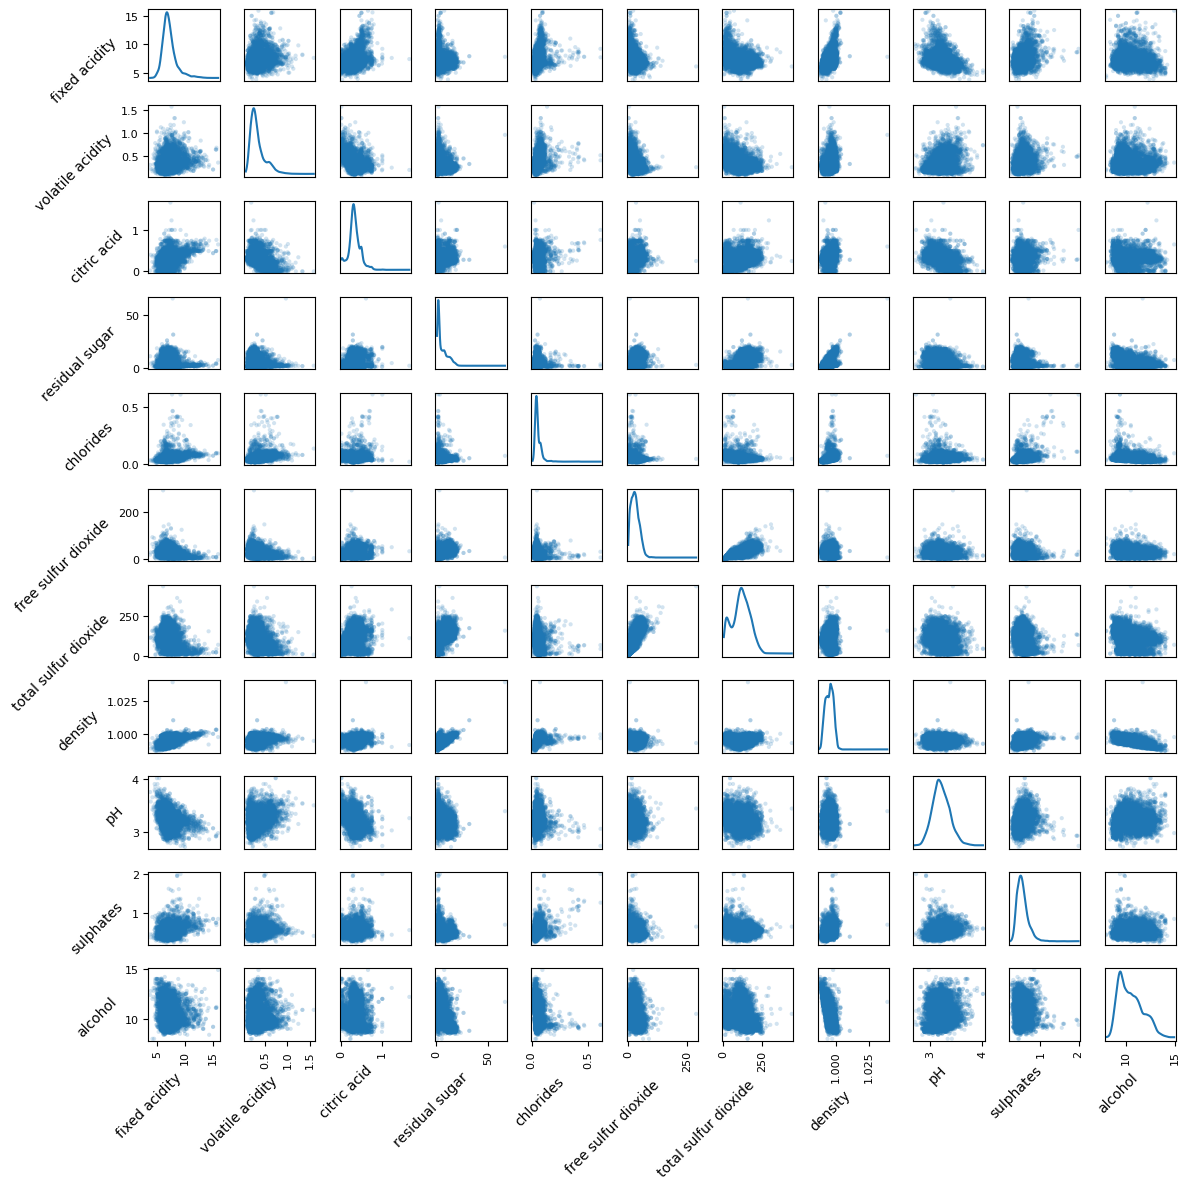

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452
volatile acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640
citric acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493
residual sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916
free sulfur dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838
total sulfur dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,0.032395,-0.238413,-0.275727,-0.265740
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,1.000000,0.011686,0.259478,-0.686745
pH,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,1.000000,0.192123,0.121248
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,1.000000,-0.003029


In [2]:
# We'll first import scikit-learn, then the loader for the data set
# from the UCI repository.
import sklearn as sk
from ucimlrepo import fetch_ucirepo
import os

# We'll import the wine data set in two parts - one for reds,
# and one for whites. The wget command from bash helps us.
# If the files already exist, no need to download them again.
if not (os.path.exists('winequality-red.csv') and os.path.exists('winequality-white.csv')):
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

red_wine = pd.read_csv('winequality-red.csv', delimiter = ';')
white_wine = pd.read_csv('winequality-white.csv', delimiter = ';')

# Now to add the colors as a column...
red_wine['color'] = 'red'
white_wine['color'] = 'white'

# ...and to create a dataframe.
wine_data = pd.concat([red_wine, white_wine], ignore_index=True)
print(wine_data.head())

# We'll separate our features X and our target y.
# This is how the data has been described in the UCI page.
# Even though our first classifier task won't use the intended
# y, we'll use it later for something else!
X = wine_data.drop(['quality', 'color'], axis = 1)
color = wine_data['color']
y = wine_data['quality']
  
# Here's some information about the variables.
# We'll use the fetch_ucirepo command and some methods to do this.
print(fetch_ucirepo(id=186).variables) 

# Let's plot each variable against every other one - except for the color
# variable, which is categorical. For now, we'll focus on the continuous
# variables in the set. We'll do this with a scatterplot matrix -
# the R language has this built in, but in Python, we can use 
# pandas.plotting.scatter_matrix to make this visual.

fig, axes = plt.subplots(figsize=(12, 12))
# Drop color because it's a binary variable!
scatter = pd.plotting.scatter_matrix(X, 
                                     alpha=0.2,
                                     ax=axes,
                                     diagonal='kde')

# To make the plot readable, we'll rotate the variable labels.
for ax in scatter.ravel():
    ax.set_xlabel(ax.get_xlabel(), rotation=45, ha='right')
    ax.set_ylabel(ax.get_ylabel(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Let's also plot the correlation matrix.
X.corr().style.background_gradient(cmap = 'coolwarm')

We can see a lot of relationships (possibly!) in this plot! Some variable pairs just look like clouds, but there are some that suggest some sort of linear relationship. Let's zoom in on the plot of density versus fixed acidity.

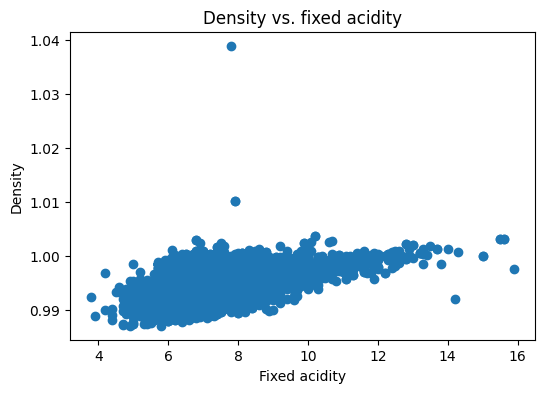

In [3]:
plt.figure(figsize = (6, 4))
plt.scatter(X['fixed acidity'], X['density'])
plt.xlabel('Fixed acidity')
plt.ylabel('Density')
plt.title('Density vs. fixed acidity')
plt.show()

There are two outliers - we can handle this in a number of ways, but let's leave them in for now. Let's try to fit a line to this pair of variables. To do this, we'll use the `LinearRegression` class provided. We'll import it to make some typing easier.

The equation of the line is density = 0.0011 * fixed_acidity + 0.9870


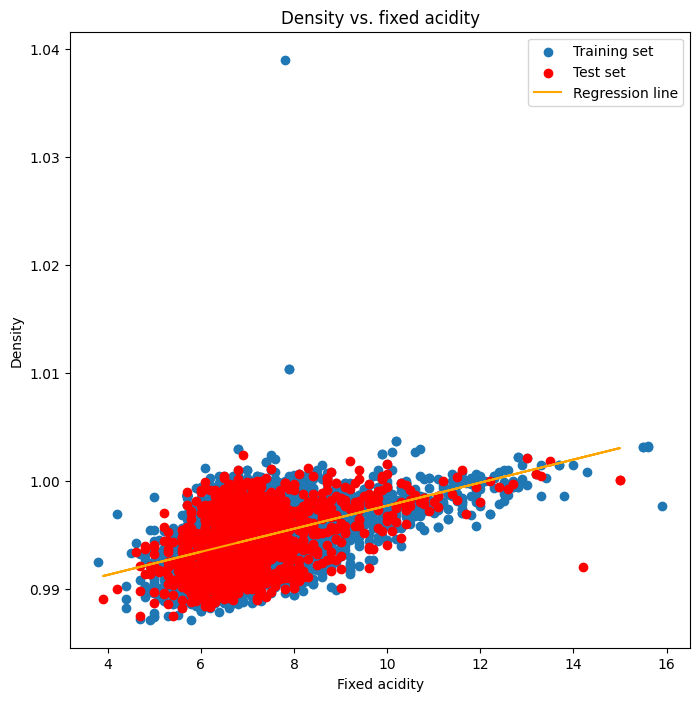

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Compute the regression coefficients.
# First, we'll identify our explanatory (independent) variable X
# and the response (dependent) variable y.
exp_var = X[['fixed acidity']]
res_var = X['density']

# Now for the usual thing in a machine learning task - train-test splits.
# 80% will be used for training, and 20% for testing.
# The random state ensures reproducibility - change it and see what happens!

exp_train, exp_test, res_train, res_test = train_test_split(exp_var, res_var, test_size = 0.2, random_state = 210)

# Next, we create the model.
model1 = LinearRegression()
model1.fit(exp_train, res_train)

# What are the coefficients?
print(f'The equation of the line is density = {model1.coef_[0]:.4f} * fixed_acidity + {model1.intercept_:.4f}')

# Let's now make a figure that contains the training data,
# the regession line, and the predictions in the test set.
# We'll store the equation of the line into a lambda function.
# (This doesn't need to be done, but it's a natural thing to do.
# If we didn't, it'd be hard to see the actual regression line!)
line_hat = lambda t: model1.coef_[0]*t + model1.intercept_
plt.figure(figsize = (8, 8))
plt.scatter(exp_train, res_train)
plt.scatter(exp_test, res_test, color = 'red')
plt.plot(exp_test, line_hat(exp_test), color = 'orange')
plt.xlabel('Fixed acidity')
plt.ylabel('Density')
plt.title('Density vs. fixed acidity')
plt.legend(['Training set', 'Test set', 'Regression line'])

plt.show()

If we wanted, we could also print some metrics related to this regression such as $R^2$ and the mean squared error - but we'll leave that as an exercise to the reader.

Other packages, such as `statsmodels` can give a full report of the statistical side of things - $p$ values, confidence intervals, test statistics, and more!

**Exercise.** Repeat the above with the total sulfur dioxide as the explanatory variable and the residual sugar as the response.

In [5]:
# Use this space to complete the exercise. Some model code has been provided for you below.


While linear regression is a supervised task, there is an analytic solution to the problem. If we wanted, we could think about multiple linear regression (fitting planes) or fitting other curves such as parabolas to the data set. The next supervised learning task we'll discuss is classification. Again, we'll use the wine data set already loaded. The task: based on the factors above, can we determine if a certain wine is a red or white.

We'll showcase a few different techniques here. First, let's just get a scatter plot of the previous two variables we used, but this time colored by the color of wine.

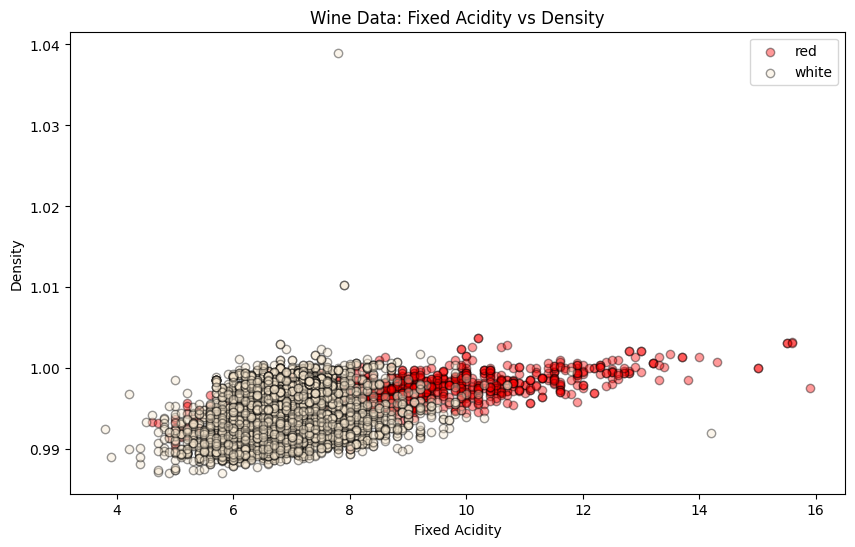

In [6]:
# Define colors for the two types of wines
colors = {'red': 'red', 'white': '#F7E7CE'}

# Create the scatter plot
plt.figure(figsize=(10, 6))
for wine_color in ['red', 'white']:
    subset = wine_data[wine_data['color'] == wine_color]
    plt.scatter(
        subset['fixed acidity'], subset['density'],
        c=colors[wine_color], label=wine_color, alpha=0.4, edgecolor='k'
    )

# Add plot labels and title
plt.xlabel('Fixed Acidity')
plt.ylabel('Density')
plt.title('Wine Data: Fixed Acidity vs Density')
plt.legend()
plt.show()

It looks like the red wines have higher acidity (it makes sense if you know about wine chemistry). How can we visualize this? Let's first use linear discriminant analysis (LDA).

[[  -0.97330888 -218.6675696 ]]
[226.16434633]


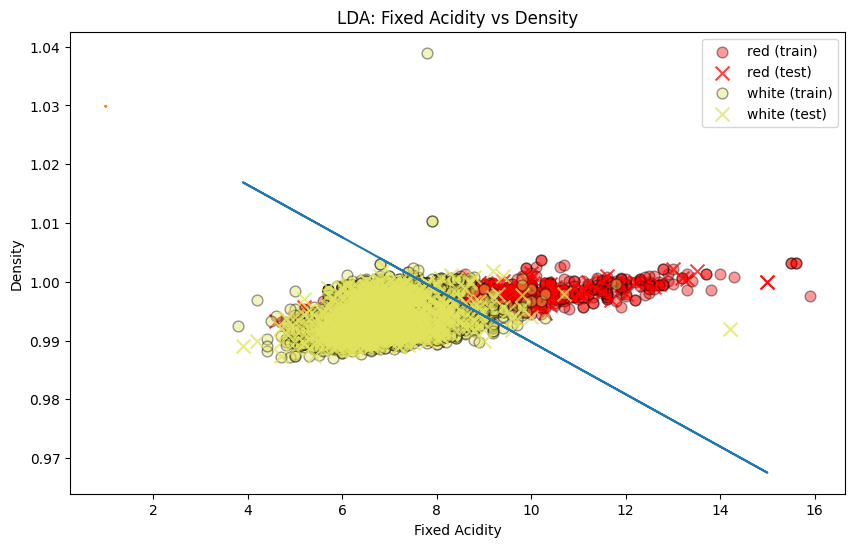

<Figure size 640x480 with 0 Axes>

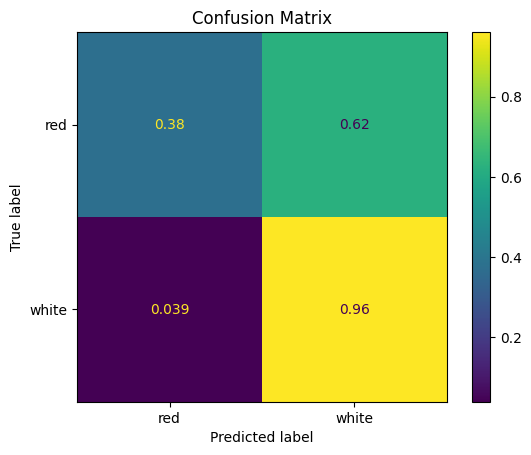

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# We'll also import the confusion matrix method - this is for later.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# We'll use the same training and test set as before.
# First, make an LDA object, then fit the model.
lda_data = X[['fixed acidity', 'density']]
lda_train, lda_test, color_train, color_test = train_test_split(lda_data, color,
                                                                test_size = 0.2, random_state = 210)

lda = LDA()
lda.fit(lda_train, color_train)
print(lda.coef_)
print(lda.intercept_)

# Now predict.
color_pred = lda.predict(lda_test)

# Let's plot the results. Training data is marked as circles,
# and test data is marked as crosses.
plt.figure(figsize=(10, 6))

colors = {'red': 'red', 'white': '#E1E35D'}

# This block gives a nice way of plotting the training and
# test data.
for wine_color, data, labels, marker, label_suffix in [
    ('red', lda_train, color_train, 'o', 'train'),
    ('red', lda_test, color_test, 'x', 'test'),
    ('white', lda_train, color_train, 'o', 'train'),
    ('white', lda_test, color_test, 'x', 'test'),
]:
    subset = data[labels == wine_color]
    plt.scatter(
        subset['fixed acidity'], subset['density'],
        c=colors[wine_color], label=f"{wine_color} ({label_suffix})",
        marker=marker, alpha=0.4 if marker == 'o' else 0.75, 
        edgecolor='k' if marker == 'o' else None, s=100 if marker == 'x' else 60
    )

# Now to also plot the decision boundary.
# We'll get the parameters for the line so we can plot it.
lda_slope, lda_int = -lda.coef_[0][0]/lda.coef_[0][1], -lda.intercept_[0]/lda.coef_[0, 1]
plt.plot(lda_test, lda_test * lda_slope + lda_int)


# As before, let's add some labels.
plt.xlabel('Fixed Acidity')
plt.ylabel('Density')
plt.title('LDA: Fixed Acidity vs Density')
plt.legend()
plt.show()

# Classification tasks are usually scored by a confusion matrix.
# This determines how many items were correctly placed in their classes.
conf_mat = confusion_matrix(color_test, color_pred, labels = ['red', 'white'], normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = lda.classes_)
plt.figure()
disp.plot()
plt.title('Confusion Matrix')
plt.show()

A lot of the white wines were correctly classified! The model seems to misclassify about two-thirds of the reds as whites.

Perhaps a support vector machine (SVM) will fare better? An SVM solves the optimization problem

$$
\begin{align*}
\min_{w, b, \lambda} \frac{1}{2} ||w||^2 + C\sum_{i} \lambda_i & \\
\text{subject to} \ c_i \left((w_1x_i + w_2y_i)+ b \right) &\geq 1 - \lambda_i
\end{align*}
$$

We want to minimize the size of the weight vector $w$ while also minimizing the amount of misclassified objects (the second term in the objective handles this). For our binary classifier, we want to place items in either the class with $c_i = 1$ or $c_i = -1.$ We leave detailed formulations of SVMs to advanced literature (say, _An Introduction to Statistical Learning with Python_, which is available for free).

Let's implement a support vector machine below.

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

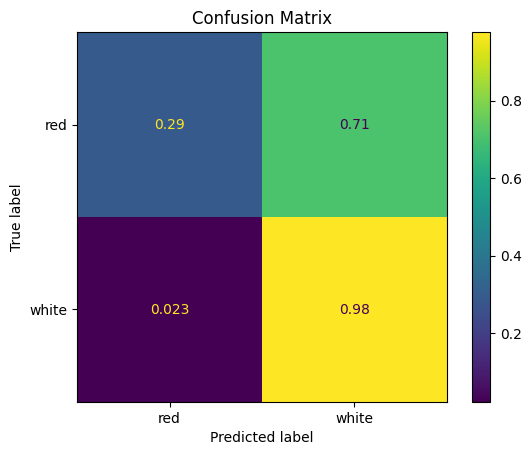

In [8]:
# scikit-learn has methods for general SVC (support vector classifier) and
# a linear one. We'll use LinearSVC with the default loss. The penalty
# term we'll choose is L1, which is more robust to outliers.
from sklearn.svm import LinearSVC

# Same training and test data from above.
svm = LinearSVC(tol = 1e-6,
                max_iter = 10000,
                loss = 'hinge',
                dual = True)

# What's next? Fit and predict!
svm.fit(lda_train, color_train)
svm_pred = svm.predict(lda_test)

# How did this do compared to the LDA? Let's check the confusion matrix.
conf_mat_svm = confusion_matrix(color_test, svm_pred, labels = ['red', 'white'], normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat_svm, display_labels = svm.classes_)
plt.figure()
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# ...still not great!

Let's now finish with nearest neighbors. The idea is simple here - take each point and consider a number of nearby points. We classify based on those around it.

Simple, right?

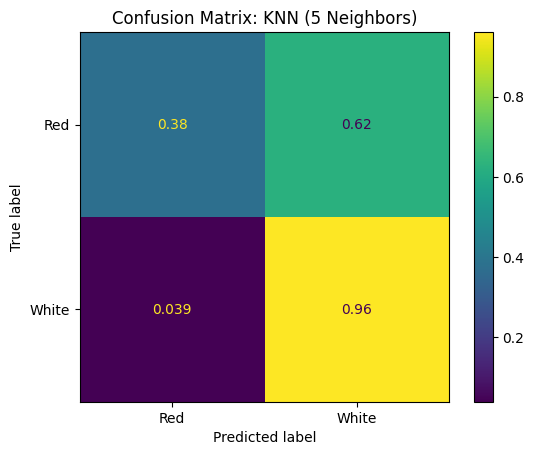

In [9]:
# Load in the k-nearest neighbors classifier.
from sklearn.neighbors import KNeighborsClassifier

# Let's try classifying with 5 neighbors.
# We'll do the usual thing - fit, predict, and assess.
knn_5 = KNeighborsClassifier(n_neighbors = 5)
knn_5.fit(lda_train, color_train)
knn_5_pred = knn_5.predict(lda_test)

# Now to tie it all together.
cm_knn5 = confusion_matrix(color_test, color_pred, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn5, display_labels=['Red', 'White'])
disp.plot()
plt.title("Confusion Matrix: KNN (5 Neighbors)")
plt.show()